#Setup

###Install

In [ ]:
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install ogb

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import random
import torch
import numpy as np
from torch_geometric.data import Data
import pickle
import glob
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import correct_and_smooth
import copy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Parameters
width = 148
height = 148
loss_fn_arg = "BCE"
model_arg = "GAT"
batch_size = 16

###Read Images and Create Train/Test Datasets.

In [4]:
# Functions
def addWatermark(img,watermark,wm_scale):
  #####################################################
  #Add watermark image on bottom right of the license plate(img)
  #  center the images at the same place
  #####################################################
  img_wm = cv2.resize(img,(148,148),interpolation=cv2.INTER_AREA)
  img_resize = copy.copy(img_wm)
  #prepare watermark image
  wm_size = (100,50) #(int(watermark.shape[1]*wm_scale),int(watermark.shape[0]*wm_scale))
  img_w = cv2.resize(watermark,wm_size,interpolation=cv2.INTER_AREA)
  h_img, w_img, _ = img_wm.shape
  center_y = int(h_img/2)
  center_x = int(w_img/2)
  h_wm, w_wm, _ = img_w.shape
  top_y = center_y - int(h_wm/2)
  left_x = center_x - int(w_wm/2)
  bottom_y = top_y + h_wm
  right_x = left_x + w_wm
  roi = img_wm[top_y:bottom_y, left_x:right_x]
  result = cv2.addWeighted(roi, 1, img_w, 1, 0)
  img_wm[top_y:bottom_y, left_x:right_x] = result
  return (img_resize, img_wm)

def loadImage(path,plotImg=True,gray_scale=False):
  #####################################################
  #Read in image path and returns an image
  #####################################################
  image = cv2.imread(path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY if gray_scale else cv2.COLOR_BGR2RGB)  
  if plotImg:
    plt.figure()
    plt.imshow(image)
    plt.show()
  return image

In [5]:
# Process an image into PyG graph.
# Each pixel is a node, and the edges are connections to neighbor pixels defined using `half_filter_dim`.
# e.g `half_filter_dim` = 1, filter size is 3*3. `half_filter_dim` = 2, filter size is 5*5.
def image_to_graph_with_filter(image, half_filter_dim):
    h, w = image.shape[:2]
    num_nodes = h * w
    edge_index = []

    for i in range(h):
        for j in range(w):
            node_id = i * w + j

            for m in range(-half_filter_dim, half_filter_dim + 1):
                for n in range(-half_filter_dim, half_filter_dim + 1):
                    if m == 0 and n == 0:
                        continue

                    neighbor_i = i + m
                    neighbor_j = j + n

                    if (0 <= neighbor_i < h) and (0 <= neighbor_j < w):
                        neighbor_id = neighbor_i * w + neighbor_j
                        edge_index.append([node_id, neighbor_id])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(image.reshape(-1, image.shape[-1]), dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

def image_to_graph_with_filter_label(x, filter_dim, y):
  graph = image_to_graph_with_filter(x, filter_dim)
  graph.y = y
  return graph

# Convert labels to tensor
def labels_to_tensor(labels):
    return torch.tensor(labels.reshape(-1, labels.shape[-1]), dtype=torch.float)

In [ ]:
!mkdir -p /content/drive/MyDrive/Dataset/Graphs/data/graphs_filter_3

In [6]:
# Create watermarked datasets: bottom right 100*100 pixels
import pandas as pd
watermark = loadImage("/content/drive/MyDrive/Dataset/Data/watermark.png",plotImg=False)
train = pd.read_csv('/content/drive/MyDrive/Dataset/Data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/Data/test.csv')
filter_dim = 3

In [ ]:
# Process all train images to graphs and save them to disk.
for i, (label, image) in enumerate(list(zip(train["Label"], train["Image"]))):
  path = '/content/drive/MyDrive/Dataset/Data/data/' + label + '/' + image
  img = loadImage(path,plotImg=False)
  img, img_wm = addWatermark(img, watermark,wm_scale=0.04)
  img = img / 255
  img_wm = img_wm / 255
  graph = image_to_graph_with_filter_label(img_wm, filter_dim, labels_to_tensor(img))
  with open(f'/content/drive/MyDrive/Dataset/Graphs/data/graphs_filter_3/train_graph_{i}.pkl', 'wb') as f:
      pickle.dump(graph, f)

# Process all test images to graphs and save them to disk.
for i, (label, image) in enumerate(list(zip(test["Label"], test["Image"]))):
  path = '/content/drive/MyDrive/Dataset/Data/data/' + label + '/' + image
  img = loadImage(path,plotImg=False)
  img, img_wm = addWatermark(img, watermark,wm_scale=0.04)
  img = img / 255
  img_wm = img_wm / 255
  graph = image_to_graph_with_filter_label(img_wm, filter_dim, labels_to_tensor(img))
  with open(f'/content/drive/MyDrive/Dataset/Graphs/data/graphs_filter_3/test_graph_{i}.pkl', 'wb') as f:
      pickle.dump(graph, f)

In [7]:
# Create a boolean mask for the watermark picture. Render the result.
path = '/content/drive/MyDrive/Dataset/Data/data/' + train["Label"][0] + '/' + train["Image"][0]
img = loadImage(path,plotImg=False)
img, img_wm = addWatermark(img, watermark,wm_scale=0.04)
mask = img != img_wm
rendered_mask = mask.astype(np.float)
plt.imshow(rendered_mask, cmap='gray', interpolation='nearest')
plt.show()

# Graph Neural Network

###Models

In [37]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.utils import softmax

class TwoLayerGCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(TwoLayerGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return x

# Custom GATConv layer with separate message passing strategies for central and neighbor nodes
class CustomGATConv(GATConv):
    def __init__(self, *args, **kwargs):
        super(CustomGATConv, self).__init__(*args, **kwargs)

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        attn_weight = torch.nn.functional.leaky_relu(alpha_j + alpha_i, negative_slope=0.2)
        alpha = softmax(attn_weight, index, ptr, size_i)
        alpha = torch.nn.functional.dropout(alpha, p=self.dropout, training=self.training)
        out = x_j * alpha.unsqueeze(-1)
        return out

# Define the custom GAT model for node classification
class CustomGAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels=16):
        super(CustomGAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, 2, dropout=0.5)
        self.conv2 = GATConv(32, 3, 1, concat=True, dropout=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

###Training

In [8]:
# Defines the customized Dataset to load data.
class DiskGraphDataset(Dataset):
    def __init__(self, root, file_name_wildcard, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.file_name_wildcard = root+file_name_wildcard
        self.graph_filenames = glob.glob(self.file_name_wildcard)

    def len(self):
        return len(self.graph_filenames)

    def get(self, idx):
        with open(self.graph_filenames[idx], 'rb') as f:
            graph = pickle.load(f)
        graph.y = labels_to_tensor(graph.y)
        return graph

In [39]:
batch_size = 16

train_graphs = DiskGraphDataset("/content/drive/My Drive/Dataset/Graphs/data/graphs_filter_3/", "train_graph_*.pkl")
test_graphs = DiskGraphDataset("/content/drive/My Drive/Dataset/Graphs/data/graphs_filter_3/", "test_graph_*.pkl")
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False, drop_last=True)

In [25]:
import pickle
import torch.optim as optim
# GNN Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model, loss function, and optimizer
model = TwoLayerGCN(3, hidden_channels=16).to(device)
if model_arg == "GAT":
  model = CustomGAT(3, hidden_channels=16).to(device)
loss_fn = torch.nn.MSELoss()
if loss_fn_arg == "BCE":
  loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

# You could also load a model check point here and skip the model training.
# model.load_state_dict(torch.load('model_checkpoint.pt'))

In [ ]:
mask = img != img_wm
mask = torch.tensor(mask).repeat(batch_size,1,1,1).reshape(-1, 3)
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
torch.save(model.state_dict(), 'model_checkpoint.pt')

<ipython-input-5-4726799d7ead>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(labels.reshape(-1, labels.shape[-1]), dtype=torch.float)


In [ ]:
# Testing
mask = img != img_wm
mask = torch.tensor(mask).repeat(batch_size,1,1,1).reshape(-1, 3)
model.eval()
loss = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        loss += loss_fn(out[mask], data.y[mask]).item()

print(f"Node-level error: {loss / len(test_loader)}")

#Correct&Smooth

In [34]:
from torch_sparse import SparseTensor
from torch_geometric.nn.models import CorrectAndSmooth
cmodel = CorrectAndSmooth (
        num_correction_layers=5,
        correction_alpha=0.5,
        num_smoothing_layers=5,
        smoothing_alpha=0.5,
    )
loss = 0
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False, drop_last=True)
mask = img != img_wm
mask = torch.tensor(mask).reshape(-1, 3)
model.eval()
predictions = []
with torch.no_grad():
  for data in test_loader:
    data = data.to(device)
    pred = model(data)
    pred = torch.sigmoid(pred)
    out = cmodel.correct(pred, data.y[torch.logical_not(mask)], torch.logical_not(mask), data.edge_index)
    out = cmodel.smooth(out, data.y[torch.logical_not(mask)], torch.logical_not(mask), data.edge_index)
    loss += loss_fn(out[mask], data.y[mask]).item()
    render = data.x.clone()
    render[mask] = out[mask]
    predictions.append(render)
print(f"Node-level error: {loss / len(test_loader)}")

<ipython-input-5-4726799d7ead>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(labels.reshape(-1, labels.shape[-1]), dtype=torch.float)


Node-level error: 0.6685345680921669


# Render Result

In [ ]:
def predict(model, test_graphs, mask):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    mask = mask.reshape((-1, 3))

    with torch.no_grad():  # Disable gradient computation during inference
        for graph in test_graphs:
            # Make predictions using the model
            graph = graph.to(device)
            output = model(graph)
            out = graph.x.clone()
            out[mask] = torch.sigmoid(output[mask])
            predictions.append(out)

    return predictions

# Use the 'predict' function to get predictions for the test_graphs
# predictions = predict(model, test_graphs, mask)

<ipython-input-37-4726799d7ead>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(labels.reshape(-1, labels.shape[-1]), dtype=torch.float)


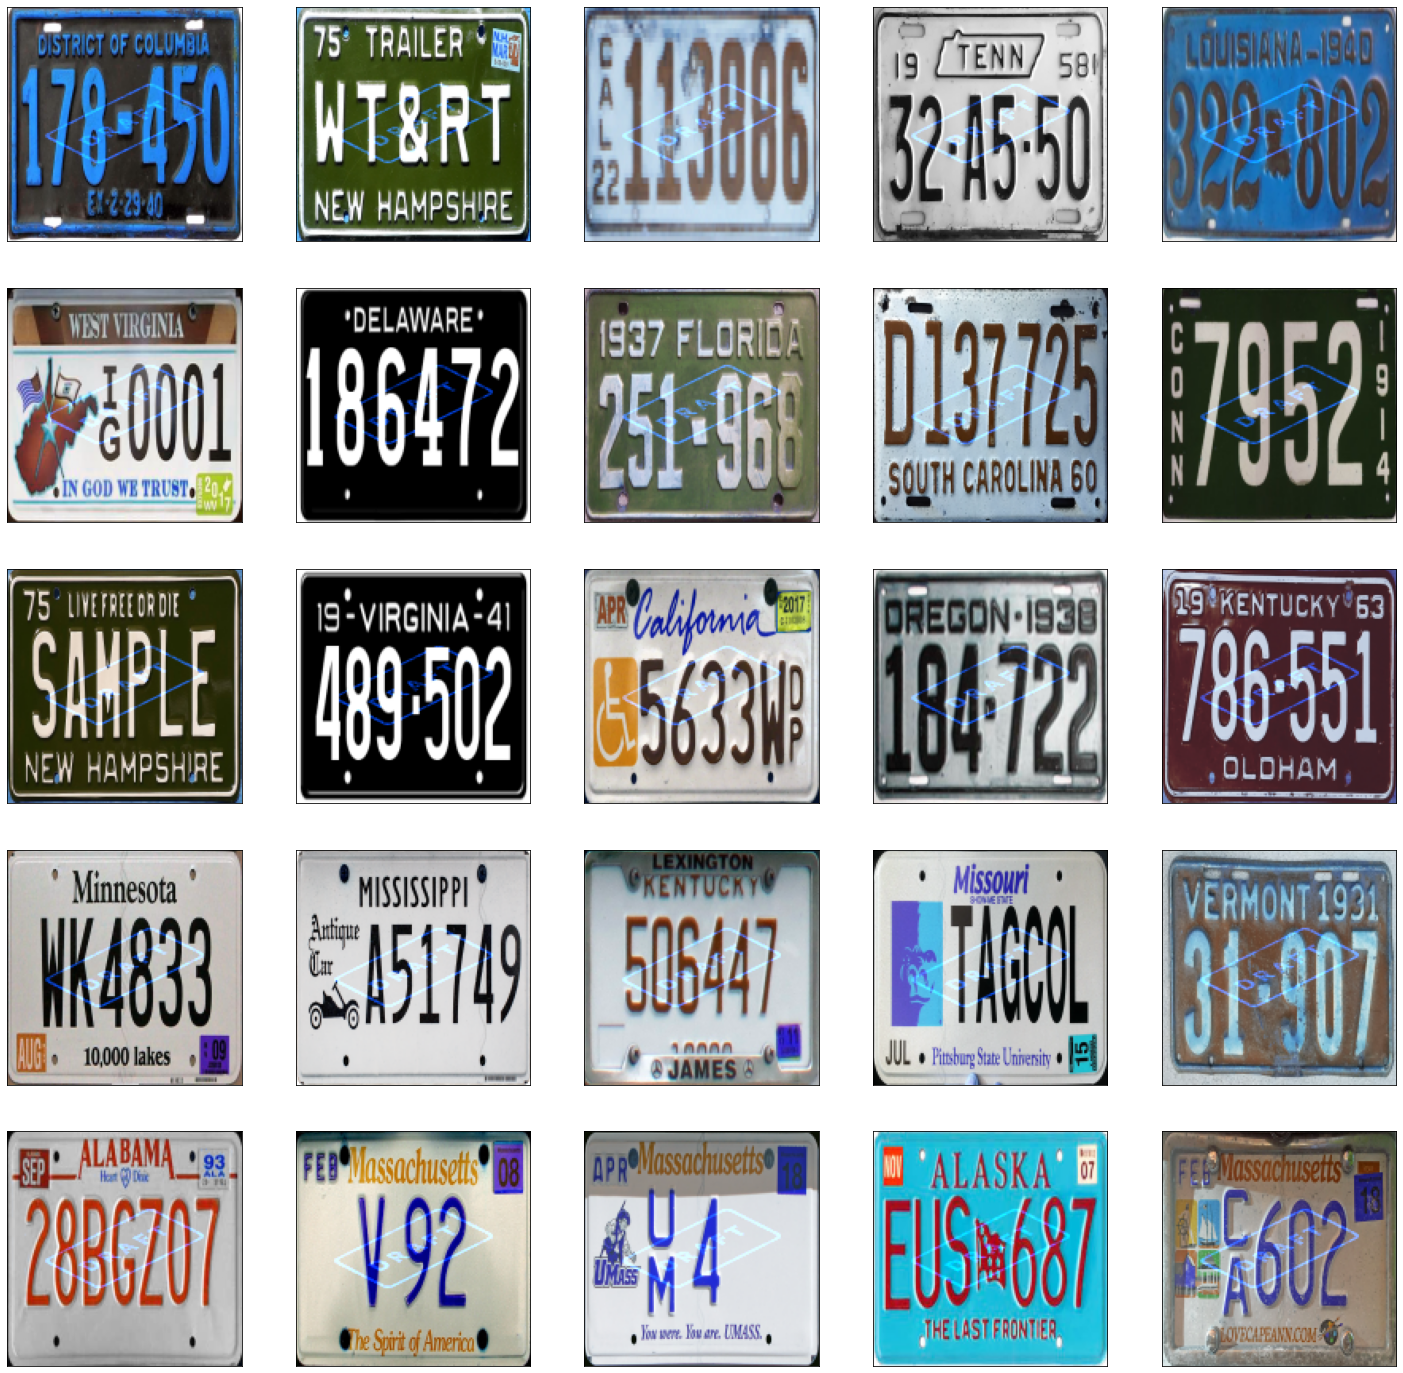

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(test_graphs[i].x.reshape(148,148,3).cpu().detach().numpy(), cv2.COLOR_BGR2RGB))
plt.show()

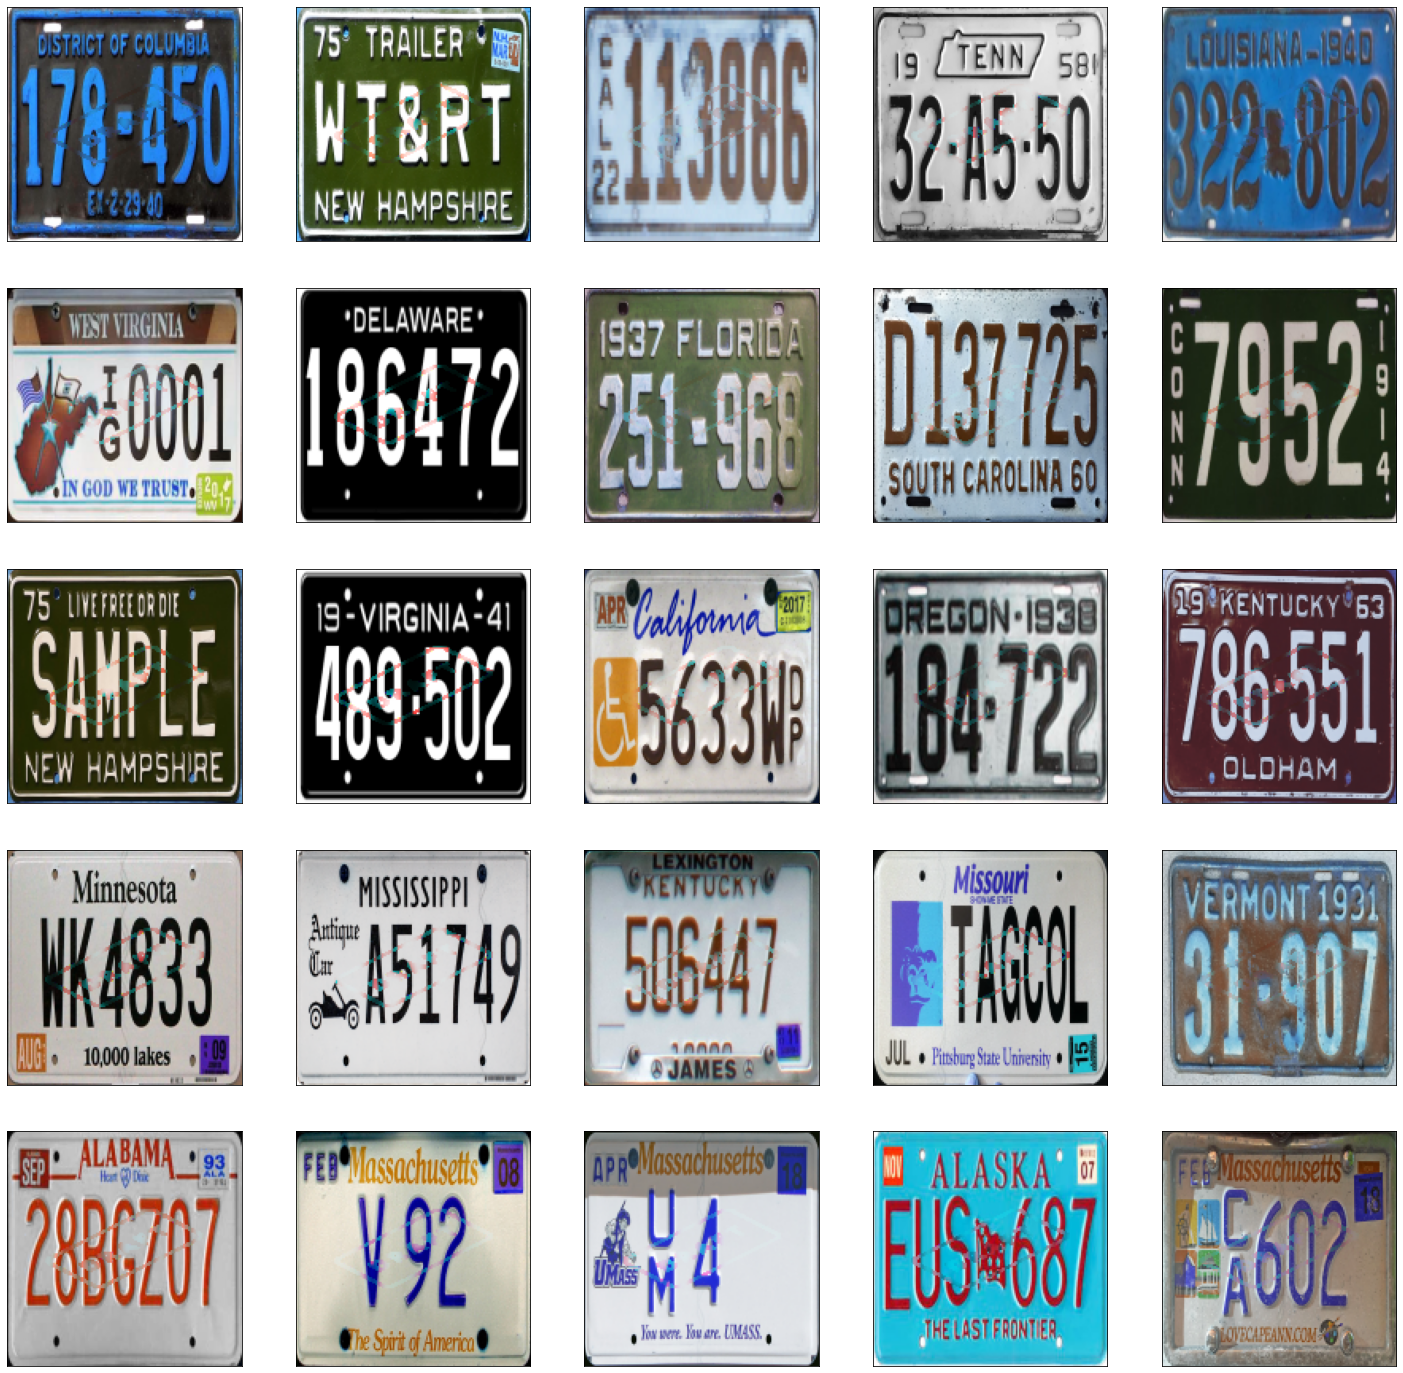

In [35]:
width = 148 # only certain dimensions work due to UpSampling (196x196 works, 148x148 works)
height = 148
dim = (width, height) # set the dimensions
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(predictions[i].reshape(width,height,3).cpu().detach().numpy(), cv2.COLOR_BGR2RGB))
plt.show()